# RFM Analysis: Customer Segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Dataset - Kaggle:  https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci

## Import Libraries

In [17]:
import warnings
# Disable all warnings
warnings.filterwarnings("ignore")

import os
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

## Load Dataset

In [3]:
# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/online_retail_II.csv")
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Data Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


1. Handle missing values, if any
2. Convert data types if necessary

In [5]:
# Check for missing values
missing_values = data.isnull().sum()
print('No. of missing values:\n {}'.format(missing_values))

# Handle missing values (example: removing rows with missing values)
data = data.dropna()

# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data.head()

No. of missing values:
 Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## RFM Calculation

In [6]:
# current date input from the user
def get_date_input():
    while True:
        try:
            date_str = input("Enter a date in YYYY-MM-DD format: ")
            year, month, day = map(int, date_str.split("-"))
            user_date = datetime(year, month, day)
            return user_date
        except ValueError:
            print("Invalid date format. Please use YYYY-MM-DD format.")

# Get the date input from the user
current_date = get_date_input()
print("You entered:", current_date)

Enter a date in YYYY-MM-DD format: 2023-08-22
You entered: 2023-08-22 00:00:00


In [7]:
# Calculate recency, frequency, and monetary values

# Convert the InvoiceDate into Datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

rfm_data = data.groupby('Customer ID').agg({'InvoiceDate': lambda x: (current_date - x.max()).days, #recency value
                                            'Invoice': 'nunique', # number of unique invoices
                                            'Price': 'sum'}).reset_index()

# Rename columns
rfm_data.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']
rfm_data.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,4598,17,580.44
1,12347.0,4275,8,644.16
2,12348.0,4348,5,193.10
3,12349.0,4291,5,1504.59
4,12350.0,4583,1,65.30


## Feature Scaling

In [8]:
scaler = StandardScaler()
scaler.fit(rfm_data[['Recency', 'Frequency', 'Monetary']])

StandardScaler()

In [9]:
rfm_scaled = scaler.transform(rfm_data[['Recency', 'Frequency', 'Monetary']])
rfm_data_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_data_scaled.head()

,Recency,Frequency,Monetary
0,0.578405,0.591554,0.036716
1,-0.946162,0.028030,0.069977
2,-0.601600,-0.159812,-0.165470
3,-0.870642,-0.159812,0.519110
4,0.507605,-0.410267,-0.232180


## K-Mean Clustering

Determine the optimal number of clusters using techniques like the Elbow Method or Silhouette Score.

The Elbow method is a common technique to determine the optimal number of clusters in K-Means clustering. It involves plotting the within-cluster sum of squares (WCSS) for different values of k (number of clusters) and looking for the "elbow point" where the rate of decrease in WCSS slows down.
The idea is to find a point where adding more clusters doesn't significantly reduce WCSS, indicating that adding more clusters doesn't provide much additional explanatory power.

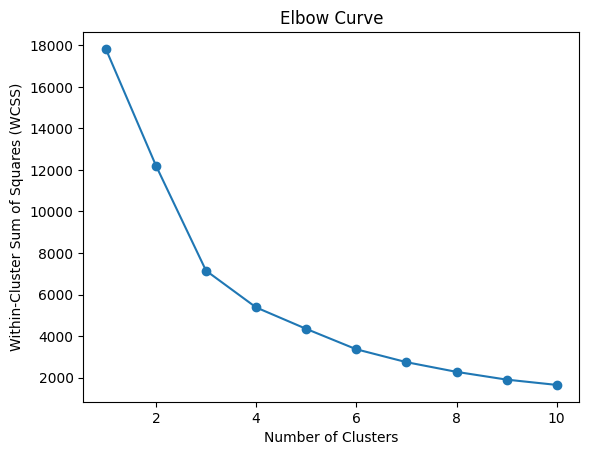

In [13]:
np.random.seed(42)
# Calculate WCSS for different values of k
wcss = []
for k in range(1, 11):  # Try different values of k from 1 to 10
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)  # Inertia is another name for WCSS


# Plot the Elbow Curve
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Curve')
plt.show()



In [14]:
# Let the optimal number of clusters be 3
n_clusters = 3

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm_data.head()

,Customer ID,Recency,Frequency,Monetary,Cluster
0,12346.0,4598,17,580.44,0
1,12347.0,4275,8,644.16,1
2,12348.0,4348,5,193.10,1
3,12349.0,4291,5,1504.59,1
4,12350.0,4583,1,65.30,0


## Visualization

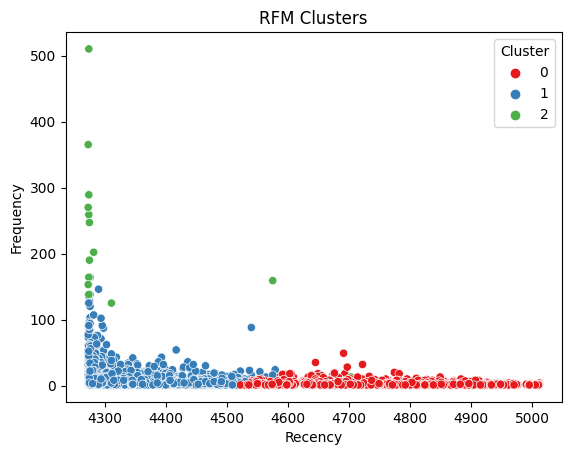

In [16]:
# Visualize the clusters
sns.scatterplot(data=rfm_data, x='Recency', y='Frequency', hue='Cluster', palette='Set1')
plt.title('RFM Clusters')
plt.show()


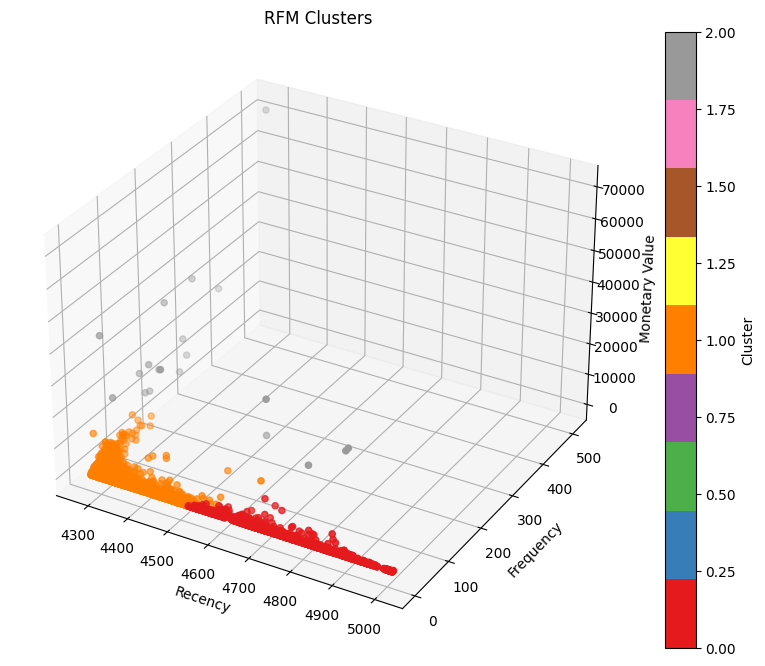

In [19]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Visualize the clusters
scatter = ax.scatter(
    rfm_data['Recency'],
    rfm_data['Frequency'],
    rfm_data['Monetary'],
    c=rfm_data['Cluster'],
    cmap='Set1'
)

# Customize labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')
ax.set_title('RFM Clusters')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()


The RFM clustering results show that there are three distinct clusters of customers:

**Cluster 0**: These customers are the most recent and frequent buyers, and they also have the highest monetary value. They are the most valuable customers to the business, and they should be targeted with marketing campaigns that encourage them to continue spending. <br>
**Cluster 1**: These customers are less recent than Cluster 0, but they are still relatively frequent buyers. They have a lower monetary value than Cluster 0, but they are still valuable customers. They should be targeted with marketing campaigns that encourage them to increase their spending. <br>
**Cluster 2**: These customers are the least recent and frequent buyers, and they also have the lowest monetary value. They are the least valuable customers to the business, and they may be at risk of churning. They should be targeted with marketing campaigns that encourage them to become more active. <br>


In [23]:
from tabulate import tabulate

# Define the cluster characteristics
cluster_characteristics = [
    [0, 'Most valuable customers', 'Most recent', 'Frequent buyers', 'Highest monetary value'],
    [1, 'Moderately valuable customers', 'Less recent', 'Relatively frequent buyers', 'Moderate monetary value'],
    [2, 'Least valuable customers', 'Least recent', 'Least frequent buyers', 'Lowest monetary value']
]

# Create a table using tabulate
table = tabulate(
    cluster_characteristics,
    headers=['Cluster', 'Description', 'Recency', 'Frequency', 'Monetary Value'],
    tablefmt='grid'
)

print(table)


+-----------+-------------------------------+--------------+----------------------------+-------------------------+
|   Cluster | Description                   | Recency      | Frequency                  | Monetary Value          |
+===========+===============================+==============+============================+=========================+
|         0 | Most valuable customers       | Most recent  | Frequent buyers            | Highest monetary value  |
+-----------+-------------------------------+--------------+----------------------------+-------------------------+
|         1 | Moderately valuable customers | Less recent  | Relatively frequent buyers | Moderate monetary value |
+-----------+-------------------------------+--------------+----------------------------+-------------------------+
|         2 | Least valuable customers      | Least recent | Least frequent buyers      | Lowest monetary value   |
+-----------+-------------------------------+--------------+------------